## Stock Market Sentiment Analysis

### Importing all libraries and loading all of the data
The dataset has been taken from the following link: https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset. <br>
The dataset consists of 2 columns, the text and the sentiment. The sentiment column has two values Positve(1) and Negative(-1)


In [203]:
# This must only be run if using a notebook, if on a custom server, use the requirements.txt file
!pip install numpy pandas torch nltk seaborn matplotlib scikit-learn

In [204]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# filename = "../data/stock_data.csv"
# The above filepath must be used if using locally
filename = "stock_data.csv"


df = pd.read_csv(filename)

df.head()

,Text,Sentiment
0,SAM cheers to the temporary solution to our ec...,positive
1,SK to the GAVE!,negative
2,ovti ttm ending Oct 2012 Negative 151 million ...,negative
3,AAP and GOOG should respond positively to good...,positive
4,Analyst price targets and earnings targets com...,positive


The dataset consists of 5791 unique values, more will can be added over time to make the model hallucinate less

In [205]:
df.describe()

,Text,Sentiment
count,1952,1952
unique,1952,2
top,SAM cheers to the temporary solution to our ec...,positive
freq,1,1352


Adding an ID attribute can be used to uniquely identify eacg value in the dataframe

In [206]:
df.insert(0, "id", range(0 + len(df)))
df.head()

,id,Text,Sentiment
0,0,SAM cheers to the temporary solution to our ec...,positive
1,1,SK to the GAVE!,negative
2,2,ovti ttm ending Oct 2012 Negative 151 million ...,negative
3,3,AAP and GOOG should respond positively to good...,positive
4,4,Analyst price targets and earnings targets com...,positive


Since we have a GPU available we will be using the GPU itself

In [207]:
cuda = torch.cuda.is_available()
device:str = ""
if cuda :
    torch.device("cuda")
    device="cuda"
else:
    torch.device("cpu")
    device="cpu"
print("This notebook will be the using -> " + device)

This notebook will be the using -> cuda


### Creating the Training and the testing splits of the data

In [208]:
RANDOM_SEED = 42

X,y = df['Text'].values,df['Sentiment'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=RANDOM_SEED,test_size=0.15,shuffle=True)
print(f'The shape of the training data -> {X_train.shape}')
print(f'The shape of the testing data -> {y_train.shape}')

The shape of the training data -> (1659,)
The shape of the testing data -> (1659,)


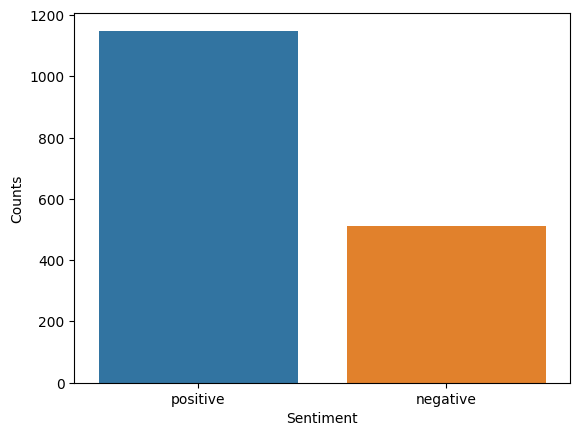

In [209]:
dd = pd.Series(y_train).value_counts()
bplot = sns.barplot(x=np.array(['positive','negative']),y=dd.values,seed=RANDOM_SEED)
bplot.set(xlabel="Sentiment",ylabel="Counts")
plt.show()

Preprocessing the String and using OneHotEncoding, Tokenizing the dataset

In [210]:
import nltk
#Downloading the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [211]:
from nltk.corpus import stopwords

# Removing everything that is not a valid word/number
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    words = []

    # We do not need words like "A,An,The. These are stopwords and must be removed"
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                words.append(word)

    corpus = Counter(words)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    # Converted nested sequences
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [212]:
x_train,y_train,x_test,y_test,vocab = tokenize(X_train,y_train,X_test,y_test)

<ipython-input-211-772a8b752636>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


The warning thta we get above states that we must convert the type of the array to object, however, we cannot do that. A numpy array of dypte=object cannot be loaded into a TensorDataset directly and creating our own tensor dataset would not be efficient as using the model with the warning will not cause any errors

In [213]:
print(f"The length of the vocabulary is {len(vocab)}")
print(f"The length of the X_train is {len(X_train)}")
print(f"The length of the X_test is {len(X_test)}")
print(f"The length of the y_train is {len(y_train)}")
print(f"The length of the y_test is {len(y_test)}")

The length of the vocabulary is 1000
The length of the X_train is 1659
The length of the X_test is 293
The length of the y_train is 1659
The length of the y_test is 293


Analysing the length of all params

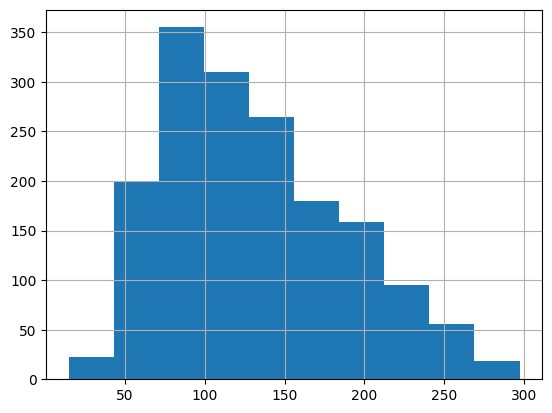

count    1659.000000
mean      131.734177
std        55.862487
min        15.000000
25%        87.000000
50%       122.000000
75%       168.000000
max       297.000000
dtype: float64

In [214]:
review = [len(i) for i in X_train]
pd.Series(review).hist()
plt.show()
pd.Series(review).describe()

### Based on the above graph we can make the following observation
*   The mean size is around 131
*   The smallest text is of size 15
*   The reviews are not too long, most of them are of moderate length, i.e. there are no such points exist that are extremely long or extremely short which could skew the results
*   The maximum length is 154, we need to pad all the text to make it reach the maximum input



In [215]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [216]:
x_train_pad = padding_(x_train,300)
x_test_pad = padding_(x_test,300)

Converting the data to be loaded into the model to tensors

In [217]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# batch size can be changed depending on the machine on which the work is being done
# larger batch size = faster model training however, this also means a larger
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

### Seeing what one batch looks like from our dataset

In [218]:
dataiter = iter(train_loader)
# The .next() function is deprecated and will show error here, use next(iterator)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 300])
Sample input: 
 tensor([[  0,   0,   0,  ..., 304, 654, 469],
        [  0,   0,   0,  ...,  29, 703,   1],
        [  0,   0,   0,  ..., 325,   3,  53],
        ...,
        [  0,   0,   0,  ...,  42, 870, 189],
        [  0,   0,   0,  ..., 148, 100, 870],
        [  0,   0,   0,  ..., 376, 276,  43]])
Sample input: 
 tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0])


### Defining and Creating the model

In [219]:
class StockSentiment(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.7):
        super(StockSentiment,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1]

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

### There are two main layers of this network -> Embedding and LSTM (Long Short Term Memory)
Other layers can be added depending on the consistency and loss of this model

In [220]:
no_layers = 2
vocab_size = len(vocab) + 1 #1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = StockSentiment(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.to(device)

print(model)

StockSentiment(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training the Model

In [221]:
lr=0.0001

criterion = nn.BCELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [222]:
clip = 5
epochs = 30
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

model.eval()

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()



    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.677003208434943 val_loss : 0.6458573698997497
train_accuracy : 64.13502109704642 val_accuracy : 59.044368600682596
Validation loss decreased (inf --> 0.645857).  Saving model ...
Epoch 2
train_loss : 0.6299866781090245 val_loss : 0.6122522354125977
train_accuracy : 68.89692585895118 val_accuracy : 59.38566552901023
Validation loss decreased (0.645857 --> 0.612252).  Saving model ...
Epoch 3
train_loss : 0.6135472492738203 val_loss : 0.6207552194595337
train_accuracy : 69.01748040988547 val_accuracy : 57.33788395904437
Epoch 4
train_loss : 0.6022597325570656 val_loss : 0.6094450354576111
train_accuracy : 68.89692585895118 val_accuracy : 59.044368600682596
Validation loss decreased (0.612252 --> 0.609445).  Saving model ...
Epoch 5
train_loss : 0.5926852605559609 val_loss : 0.5740680813789367
train_accuracy : 68.89692585895118 val_accuracy : 60.068259385665534
Validation loss decreased (0.609445 --> 0.574068).  Saving model ...
Epoch 6
train_loss : 0.57522939461650

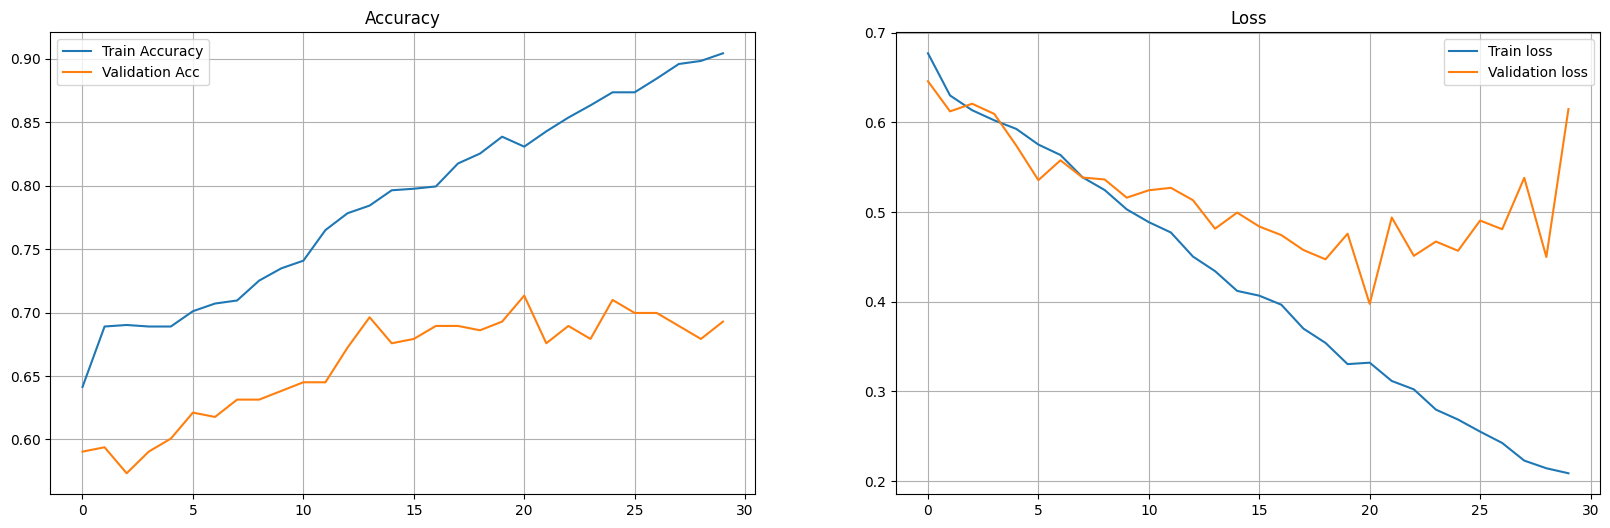

In [223]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Accuracy')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


In [224]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [225]:
index = 1000
print(df['Text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["Sentiment"][index]}')
print('='*70)
pro = predict_text(df['Text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Combining the two producers will create a strong EU-based fertilizer industry capable of meeting global competition , they added .
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9994003772735596


In [226]:
index = 526
print(df['Text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["Sentiment"][index]}')
print('='*70)
pro = predict_text(df['Text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

ADPnews - Jul 17 , 2009 - Finland-based steel maker Rautaruukki Oyj Ruukki HEL : RTRKS said today it slipped to a net loss of EUR 184 million USD 259.7 m for the first half of 2009 from a net profit of EUR 2
Actual sentiment is  : negative
predicted sentiment is negative with a probability of 0.9777376763522625


In [227]:
pro = predict_text("​Mukul Agrawal's Portfolio: 6 stocks soar over 100% in 2023 so far")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.5006832480430603


In [228]:
pro = predict_text("Apple releases new iPhone at WWDC")
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

predicted sentiment is positive with a probability of 0.5258218050003052
